In [6]:
import pandas as pd
import torch
from torch import Tensor, DoubleTensor, LongTensor

from display import display_structure
from structural.structure import (TenBarsPlanarTruss, AbstractStructure)
from structural.analysis import LinearAnalysis
from dataset import TenBarsPlanarTrussGenerator
import numpy as np

import sympy as sp
from sympy import Matrix, symbols, lambdify

In [7]:
g = TenBarsPlanarTrussGenerator("data/config/10_bar_truss_square.yaml")

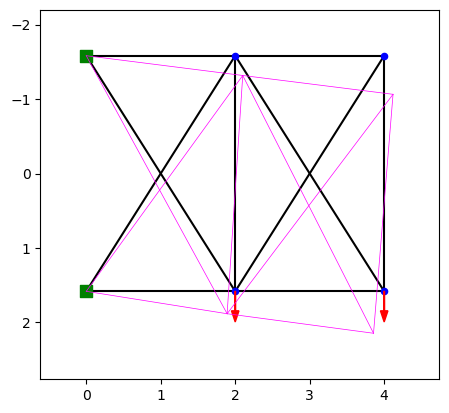

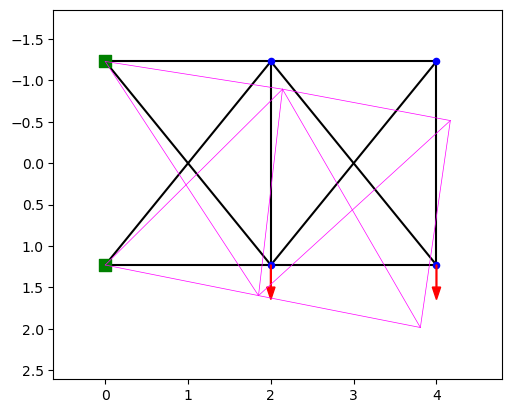

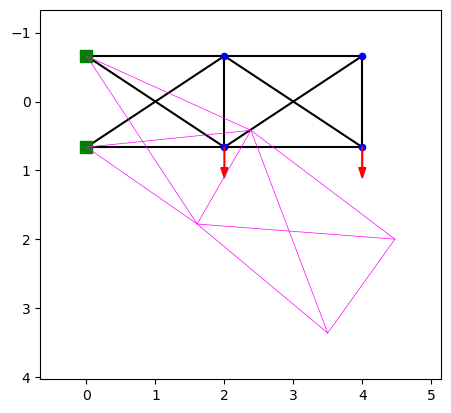

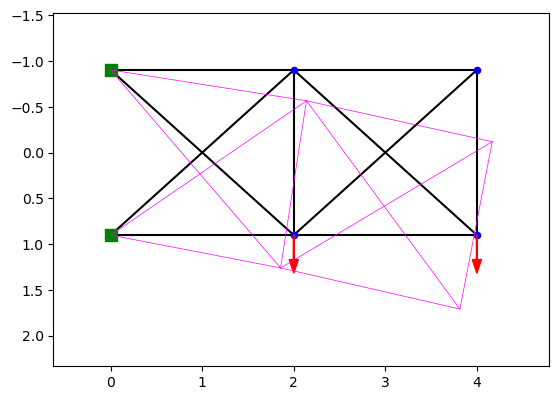

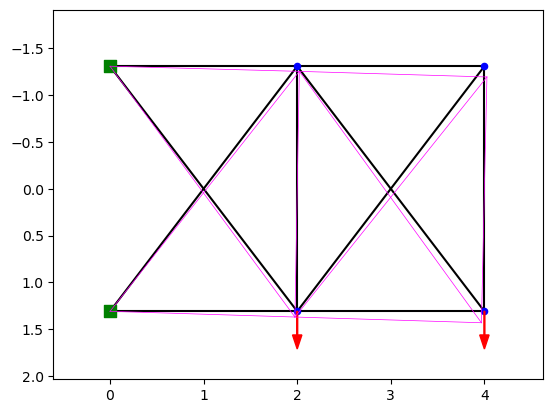

In [22]:
for i in g:
    display_structure()

# Torch batched stiffness assembly

In [12]:
def construct_k(youngs: DoubleTensor,
                areas: DoubleTensor,
                nodes: DoubleTensor,
                elems: LongTensor,
                supports: LongTensor,
                n_dof: int | None = None):
    """
    Perform a batch construction of the global stiffness matrix.

    Parameters
    ----------
    youngs : torch.DoubleTensor
        A tensor of shape (batch_size, n_elems) containing the Young's modulus for each element in the batch.
    areas : torch.DoubleTensor
        A tensor of shape (batch_size, n_elems) containing the cross-sectional area for each element in the batch.
    nodes : torch.DoubleTensor
        A tensor of shape (batch_size, n_nodes, n_dim) containing the coordinates of the nodes in the batch.
    elems : torch.LongTensor
        A tensor of shape (n_elems, 2) containing the connectivity of elements (pairs of nodes).
        It is assumed consistent along the batch.
    supports : torch.LongTensor
        A tensor of shape (n_supports,) containing the degrees of freedom (DOFs) that are fixed or supported.
        It is assumed consistent along the batch.
    n_dim : int, optional
        The number of spatial dimensions (default is 2).
    n_dof : int, optional
        The number of degrees of freedom per node (default is 3).

    Returns
    -------
    torch.DoubleTensor
        A tensor of shape (batch_size, n_nodes * n_dof, n_nodes * n_dof) representing the global stiffness matrix for the batch.
    
    Notes
    -----
    The function performs the following steps:
        1)  Extract important constants such as Young's modulus, area, and node coordinates from the batched input.
        2)  Compute the angles and lengths of the structural elements for each element in the batch.
            This is done by converting the elements into vectors and calculating their length and direction.
        3)  Compute the axial stiffness of the elements using the formula: 
            E * A / L, where E is Young's modulus, A is the area, and L is the length of the element.
        4)  Construct the global stiffness matrix by iterating over all elements in the batch, 
            computing the local stiffness matrix, rotating it using the element's angle, 
            and adding the contribution to the global stiffness matrix.
        5)  Apply support conditions by setting the appropriate rows and columns to zero and 
            setting the diagonal to one for the supported degrees of freedom in the batch.
    """

    """
    Ensure that the data is batched
    """
    if len(youngs.shape) != 2: raise ValueError("youngs is expected to be a tensor of shape (batch_size, n_elems)")
    if len(areas.shape) != 2: raise ValueError("areas is expected to be a tensor of shape (batch_size, n_elems)")
    if len(nodes.shape) != 3: raise ValueError("nodes is expected to be a tensor of shape (batch_size, n_nodes, n_dof)")
    if len(elems.shape) != 2: raise ValueError("elems is expected to be a tensor of shape (n_elems, 2)")
    if len(supports.shape) != 1: raise ValueError("supports is expected to be a tensor of shape (n_supports,)")

    """
    Preprocess the data for stiffness matrix assembly
        1)  Extract important constants
        2)  Compute angles and lengths of the structural elements
            This is done through conversion of elements to vector.
            To maintain batch operation, we unsqueeze and expand the nodes.
        3)  Compute the axial stiffness of the structural elements
    """
    batch_size, n_nodes, n_dim = nodes.shape
    n_elems: int = elems.shape[0]

    if n_dof is None: n_dof = n_dim # Truss hypothesis

    _start_nodes = elems.repeat(batch_size, 1, 1)[:, :, 0]
    _start_nodes = _start_nodes.unsqueeze(-1).expand(-1, -1, n_dim)  #(batch_size, n_elems, n_dim)
    _end_nodes = elems.repeat(batch_size, 1, 1)[:, :, 1]
    _end_nodes = _end_nodes.unsqueeze(-1).expand(-1, -1, n_dim)  #(batch_size, n_elems, n_dim

    elems_v = nodes.gather(1, _end_nodes) - nodes.gather(1, _start_nodes)  # (batch_size, n_elems, n_dim)

    lengths = torch.norm(elems_v, dim=2, dtype=torch.float64)  # (batch_size, n_elems)
    angles = torch.atan2(elems_v[:, :, 1], elems_v[:, :, 0])  # (batch_size, n_elems)

    eal = areas * youngs / lengths  # (batch_size, n_elems)

    """
    Assembly of the stiffness matrix
        1)  Allocate size of the total matrix of shape (n_nodes * n_dof, n_nodes * n_dof)
        2)  For each element:
            a)  Compute the local stiffness matrix of the element
            b)  Compute the rotation matrix of the element
            c)  Computer the global stiffness matrix of the element
            d)  Add the elements stiffness to the global stiffness matrix
        3) Apply the support:
            a)  Set row and column of the corresponding degrees of freedom to 0.
            b)  Set the diagonal to 1.
    """

    K = torch.zeros((batch_size, n_nodes * n_dof, n_nodes * n_dof),
                    dtype=torch.float64)  # (batch_size, n_nodes * n_dof, n_nodes * n_dof)
    
    _k_loc = torch.tensor([[1, 0, -1, 0],
                           [0, 0, 0, 0],
                           [-1, 0, 1, 0],
                           [0, 0, 0, 0]],
                          dtype=torch.float64)  # (batch_size, 4, 4)

    for idx in range(n_elems):
        idx_start: int = elems[idx, 0] * n_dof
        idx_end: int = elems[idx, 1] * n_dof
        angle = angles[:, idx]  # (batch_size,)

        c = torch.cos(angle)  # (batch_size,)
        s = torch.sin(angle)  # (batch_size,)

        r = torch.stack(
            [torch.stack([c, s, torch.zeros_like(c), torch.zeros_like(c)], dim=-1),
             torch.stack([-s, c, torch.zeros_like(c), torch.zeros_like(c)], dim=-1),
             torch.stack([torch.zeros_like(c), torch.zeros_like(c), c, s], dim=-1),
             torch.stack([torch.zeros_like(c), torch.zeros_like(c), -s, c], dim=-1),
             ], dim=1
        )  # (batch_size, 4, 4)

        r_t = r.transpose(1, 2)  # (batch_size, 4, 4)

        k_loc = eal[:, idx].view(-1, 1, 1) * _k_loc  # (batch_size, 4, 4)
        k_glob = torch.matmul(torch.matmul(r_t, k_loc), r)  # (batch_size, 4, 4)

        K[:, idx_start:idx_start + n_dof, idx_start:idx_start + n_dof] += k_glob[:, 0:n_dof, 0:n_dof]
        K[:, idx_end:idx_end + n_dof, idx_end:idx_end + n_dof] += k_glob[:, n_dof:2 * n_dof, n_dof:2 * n_dof]
        K[:, idx_start:idx_start + n_dof, idx_end:idx_end + n_dof] += k_glob[:, 0:n_dof, n_dof:2 * n_dof]
        K[:, idx_end:idx_end + n_dof, idx_start:idx_start + n_dof] += k_glob[:, n_dof:2 * n_dof, 0:n_dof]

    K[:, supports, :] = 0.
    K[:, :, supports] = 0.
    K[:, supports, supports] = 1

    return K

In [30]:
# System setup
n_dim = 2
n_dof = 2

n_nodes = 6
n_elems = 10

batch_size = 3

# Material
areas = torch.tensor([[10e-4 for _ in range(n_elems)] for _ in range(batch_size)],
                     dtype=torch.float64)  # (batch_size, n_elems)
youngs = torch.tensor([[70e9 for _ in range(n_elems)] for _ in range(batch_size)],
                      dtype=torch.float64)  # (batch_size, n_elems)

# Geometry
nodes = torch.tensor(np.array([g.structure.nodes_coordinates * i for i in np.linspace(1, 1, batch_size)]),
                     dtype=torch.float64)  # (batch_size, n_nodes, n_dim)

# Connectivity is assumed uniform
elems = torch.tensor(g.structure.elements_connectivity, dtype=torch.int64)  # (n_elems, 2)
supports = torch.tensor([n_dof * i + j for i, x, y in g.structure.supports for j, f in enumerate((x, y)) if f],
                        dtype=torch.int64)

K = construct_k(youngs, areas, nodes, elems, supports)
K[0] - g.structure.stiffness_matrix

torch.Size([3, 12, 12])
0.0
0.0
0.0
0.0
1.5707963267948966
1.5707963267948966
0.7853981633974483
-0.7853981633974483
0.7853981633974483
-0.7853981633974483


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.8626e-09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.8626e-09,  3.7253e-09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.8626e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8626e-09,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.8626e-09,
      

In [17]:
# System setup
n_dim = 2
n_dof = 2

n_nodes = 6
n_elems = 10

batch_size = 3

# Material
areas = torch.tensor([[10e-4 for _ in range(n_elems)] for _ in range(batch_size)],
                     dtype=torch.float64)  # (batch_size, n_elems)
youngs = torch.tensor([[70e9 for _ in range(n_elems)] for _ in range(batch_size)],
                      dtype=torch.float64)  # (batch_size, n_elems)

# Geometry
nodes = torch.tensor(np.array([g.structure.nodes_coordinates * i for i in np.linspace(1, 1, batch_size)]),
                     dtype=torch.float64)  # (batch_size, n_nodes, n_dim)

# Connectivity is assumed uniform
elems = torch.tensor(g.structure.elements_connectivity, dtype=torch.int64)  # (n_elems, 2)
supports = torch.tensor([n_dof * i + j for i, x, y in g.structure.supports for j, f in enumerate((x, y)) if f],
                        dtype=torch.int64)

# The unsqueeze and expand duplicate the last value so we select both nodes coordinates on the last dim.
_start_nodes = elems.repeat(batch_size, 1, 1)[:, :, 0].unsqueeze(-1).expand(-1, -1,
                                                                            n_dim)  # (batch_size, n_elems, n_dim)
_end_nodes = elems.repeat(batch_size, 1, 1)[:, :, 1].unsqueeze(-1).expand(-1, -1, n_dim)  # (batch_size, n_elems, n_dim)

elems_v = nodes.gather(1, _end_nodes) - nodes.gather(1, _start_nodes)  # (batch_size, n_elems, n_dim)

# Determine length and angles
lengths = torch.norm(elems_v, dim=2, dtype=torch.float64)  # (batch_size, n_elems)
angles = torch.atan2(elems_v[:, :, 1], elems_v[:, :, 0])  # (batch_size, n_elems)

eal = areas * youngs / lengths  # (batch_size, n_elems)

K = torch.zeros((batch_size, n_nodes * n_dof, n_nodes * n_dof),
                dtype=torch.float64)  # (batch_size, n_nodes * n_dof, n_nodes * n_dof)
k_loc_ref = torch.tensor([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]],
                         dtype=torch.float64)  # (batch_size, 4, 4)

for idx in range(n_elems):
    idx_start: int = elems[idx, 0] * n_dof
    idx_end: int = elems[idx, 1] * n_dof
    angle = angles[:, idx]  # (batch_size,)

    c = torch.cos(angle)  # (batch_size,)
    s = torch.sin(angle)  # (batch_size,)

    # Create the rotation matrix
    r = torch.stack(
        [torch.stack([c, s, torch.zeros_like(c), torch.zeros_like(c)], dim=-1),  # First row: [c, s, 0, 0]
         torch.stack([-s, c, torch.zeros_like(c), torch.zeros_like(c)], dim=-1),  # Second row: [-s, c, 0, 0]
         torch.stack([torch.zeros_like(c), torch.zeros_like(c), c, s], dim=-1),  # Third row: [0, 0, c, s]
         torch.stack([torch.zeros_like(c), torch.zeros_like(c), -s, c], dim=-1),  # Fourth row: [0, 0, -s, c]
         ], dim=1
    )  # (batch_size, 4, 4)

    r_t = r.transpose(1, 2)  # (batch_size, 4, 4)

    k_loc = eal[:, idx].view(-1, 1, 1) * k_loc_ref  # (batch_size, 4, 4)
    k_glob = torch.matmul(torch.matmul(r_t, k_loc), r)  # (batch_size, 4, 4)

    K[:, idx_start:idx_start + n_dof, idx_start:idx_start + n_dof] += k_glob[:, 0:n_dof, 0:n_dof]
    K[:, idx_end:idx_end + n_dof, idx_end:idx_end + n_dof] += k_glob[:, n_dof:2 * n_dof, n_dof:2 * n_dof]
    K[:, idx_start:idx_start + n_dof, idx_end:idx_end + n_dof] += k_glob[:, 0:n_dof, n_dof:2 * n_dof]
    K[:, idx_end:idx_end + n_dof, idx_start:idx_start + n_dof] += k_glob[:, n_dof:2 * n_dof, 0:n_dof]

K[:, supports, :] = 0.
K[:, :, supports] = 0.
K[:, supports, supports] = 1

K_ref = K[0]

# Symbolic stiffness matrix

In [162]:
h, l = symbols('h l')
L = [l for _ in range(4)] + [h for _ in range(2)] + [(l ** 2 + h ** 2) ** .5 for _ in range(4)]
A = [symbols(f"a_{i}") for i in range(10)]
E = [symbols(f"e_{i}") for i in range(10)]
n_dof = 2

nodes = g.structure.nodes_coordinates
elems = g.structure.elements_connectivity

elems_vec = np.array([nodes[e] - nodes[s] for s, e in elems])
elems_angle = np.array([np.arctan2(*v[::-1]) - np.arctan2(0, 1) for v in elems_vec])

K = Matrix.zeros(12, 12)
for idx in range(len(elems)):
    s_i = elems[idx][0] * n_dof
    e_i = elems[idx][1] * n_dof

    angle: float = elems_angle[idx]

    c = sp.cos(angle)
    s = sp.sin(angle)

    r = Matrix([[c, s, 0, 0], [-s, c, 0, 0], [0, 0, c, s], [0, 0, -s, c]])

    k_loc = E[idx] * A[idx] / L[idx] * Matrix([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])

    k_glob = r.T @ k_loc @ r

    for i in range(n_dof):
        for j in range(n_dof):
            # Up left
            K[s_i + i, s_i + j] += k_glob[0 + i, 0 + j]
            # Up right
            K[s_i + i, e_i + j] += k_glob[0 + i, n_dof + j]
            # Down left
            K[e_i + i, s_i + j] += k_glob[n_dof + i, 0 + j]
            # Down right
            K[e_i + i, e_i + j] += k_glob[n_dof + i, n_dof + j]

for i in (0, 1, 6, 7):
    for j in range(12):
        K[i, j] = 0
        K[j, i] = 0
    K[i, i] = 1

sub = {'h': 2, 'l': 2}
sub.update({f'a_{i}': 10e-4 for i in range(10)})
sub.update({f'e_{i}': 70e9 for i in range(10)})

# K = sp.nsimplify(K, tolerance=1e-10, rational=True)
# s = K.__str__()
# for i in range(10):
#     s = s.replace(f"a_{i}", f"a[{i}]")
#     s = s.replace(f"e_{i}", f"e[{i}]")
# s = s.replace("sqrt", "np.sqrt")
# s = "def f(e, a, l ,h):\n\treturn np.array" + s[6:]
# print(s)

np.round(np.array(K.subs(sub), dtype=float), 5)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.47487373e+07,
         0.00000000e+00, -3.50000000e+07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -1.23743687e+07, -1.23743687e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.97487373e+07,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -3.50000000e+07, -1.23743687e+07, -1.23743687e+07],
       [ 0.00000000e+00,  0.00000000e+00, -3.5000000